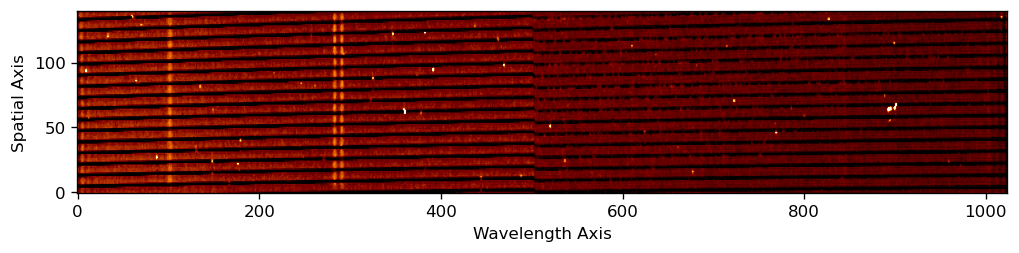

In [2]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code/')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load waverange
waverange = fits.open(filepath + 'order34/waverange.fits', ignore_missing_end=True)[0].data

# load skylines
skylines60m = fits.open(filepath + 'order34/skylines60m_order34.fits', ignore_missing_end=True)[0].data
skylines60p = fits.open(filepath + 'order34/skylines60p_order34.fits', ignore_missing_end=True)[0].data
skylines60p_shifted = fits.open(filepath + 'order34/skylines60p_shifted_order34.fits', ignore_missing_end=True)[0].data

plt.figure(figsize=(10,2))
plt.imshow(skylines60m, aspect='auto', cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 1024
    # variables        = 2
    chi-square         = 4.8524e-12
    reduced chi-square = 4.7479e-15
    Akaike info crit   = -33770.6179
    Bayesian info crit = -33760.7549
[[Variables]]
    slope:      3.1000e-05 +/- 7.2844e-12 (0.00%) (init = 3.1e-05)
    intercept:  2.24285102 +/- 4.3034e-09 (0.00%) (init = 2.242851)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.866


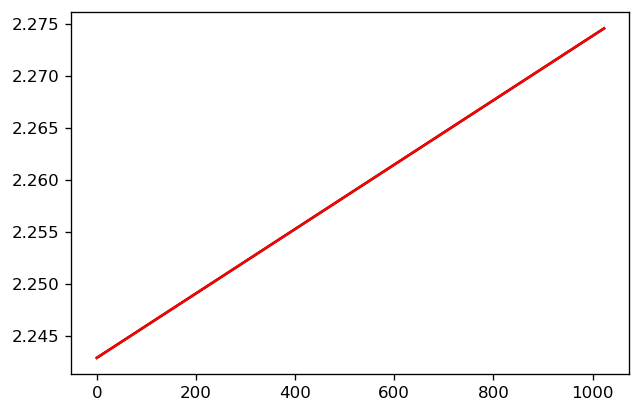

In [3]:
waveaxis = np.linspace(0, 1023, 1024)

mod = LinearModel()

pars = mod.guess(waverange, x=waveaxis)
out = mod.fit(waverange, pars, x=waveaxis)

print(out.fit_report(min_correl=0.25))

m = out.params['slope'].value
y0 = out.params['intercept'].value

wave_best_fit = m*waveaxis + y0

plt.figure()
plt.plot(waveaxis, waverange,'k', label = 'original')
plt.plot(waveaxis, wave_best_fit, 'r', label = 'best fit')

Text(0, 0.5, '$\\mathrm{ph/sec/arcsec^2/nm/m^2}$')

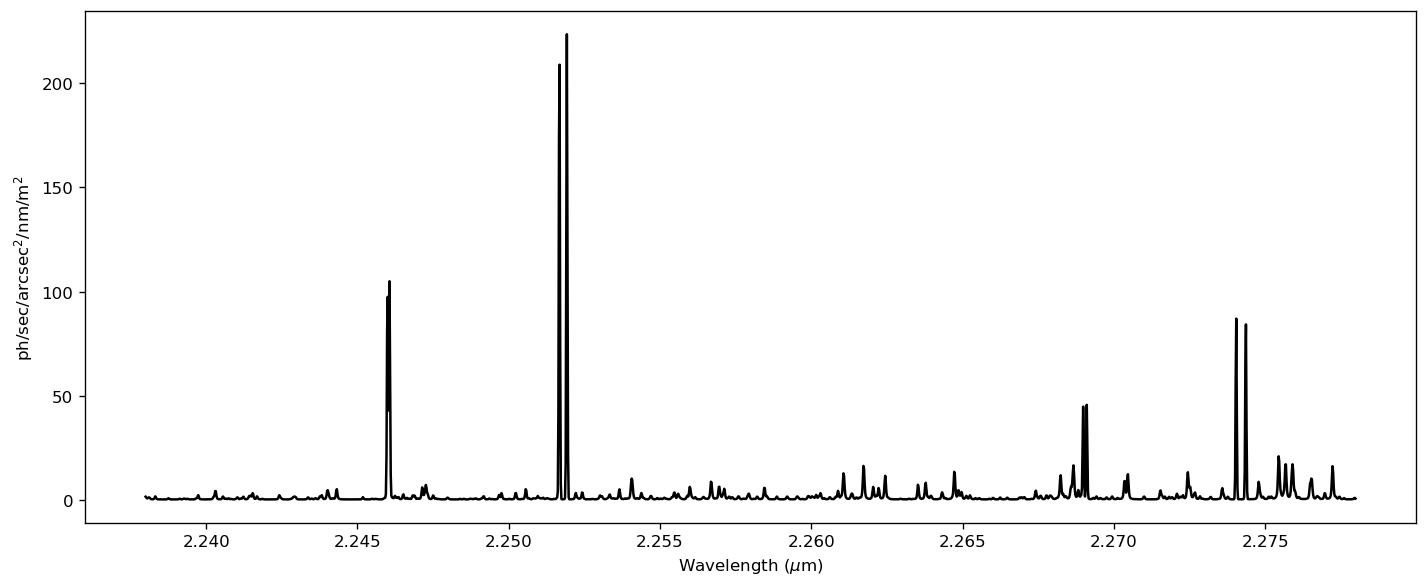

In [5]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[66900:68900,0]/1000)
count = gemini_array[66900:68900,1]
#2.177-2.209

fig = plt.figure(figsize=(12,5), tight_layout=True)

fig.add_subplot(111)
plt.plot(wavelength, count, 'k', label='original')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\mathrm{ph/sec/arcsec^2/nm/m^2}$')
# plt.xlim(2.245,2.25)

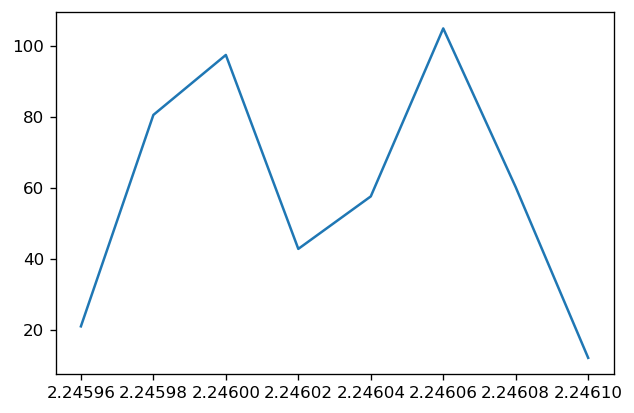

In [164]:
plt.plot(wavelength[398:406], count[398:406])

In [7]:
wavelength[397:407]

array([2.24594, 2.24596, 2.24598, 2.246  , 2.24602, 2.24604, 2.24606,
       2.24608, 2.2461 , 2.24612])

In [14]:
count[397:407]

array([  2.868541,  21.07985 ,  80.62073 ,  97.50829 ,  42.89431 ,
        57.67347 , 104.9847  ,  60.27154 ,  12.20545 ,   2.151227])

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 23
    # variables        = 6
    chi-square         = 1.37645819
    reduced chi-square = 0.08096813
    Akaike info crit   = -52.7675526
    Bayesian info crit = -45.9545873
[[Variables]]
    a0:  224.792523 +/- 0.28329861 (0.13%) (init = 200)
    a1:  2.25167302 +/- 2.5502e-08 (0.00%) (init = 2.25168)
    a2:  8.6387e-04 +/- 8.7920e-07 (0.10%) (init = 0.001)
    a3: -204824.664 +/- 2761903.75 (1348.42%) (init = 0)
    a4:  182189.847 +/- 2453267.52 (1346.54%) (init = 0)
    a5: -40513.9176 +/- 544780.185 (1344.67%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -1.000
    C(a4, a5) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.493
2.2516730208690925


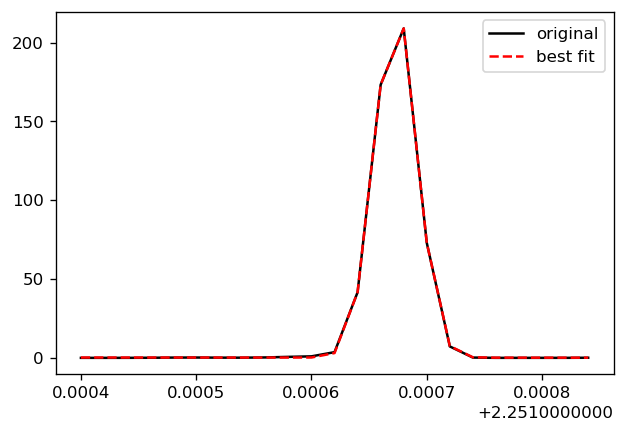

In [29]:
x1 = wavelength[670:693]
y1 = count[670:693]

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=200, min=170)
g1_params.add('a1', value=2.25168, max=2.2518)
g1_params.add('a2', value=0.001)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(y1, g1_params, x=x1)
except:
    pass

print(g1_result.fit_report())

plt.figure()
plt.plot(x1, y1, 'k', label='original')
plt.plot(x1, g1_result.best_fit, 'r--', label='best fit')
plt.legend()

print(g1_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 22
    # variables        = 6
    chi-square         = 0.88217265
    reduced chi-square = 0.05513579
    Akaike info crit   = -58.7610189
    Bayesian info crit = -52.2147642
[[Variables]]
    a0:  223.632833 +/- 0.23289576 (0.10%) (init = 220)
    a1:  2.25192102 +/- 2.1393e-08 (0.00%) (init = 2.25192)
    a2:  8.6546e-04 +/- 7.9606e-07 (0.09%) (init = 0.004)
    a3: -609.123155 +/- 3085894.40 (506612.56%) (init = 0)
    a4: -293.726862 +/- 2740604.99 (933045.40%) (init = 0)
    a5:  250.620825 +/- 608487.764 (242792.18%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a2, a3) = -0.493
    C(a2, a4) =  0.493
    C(a2, a5) = -0.493
    C(a0, a2) = -0.480
    C(a0, a5) =  0.173
    C(a0, a4) = -0.173
    C(a0, a3) =  0.173
2.2519210166817167


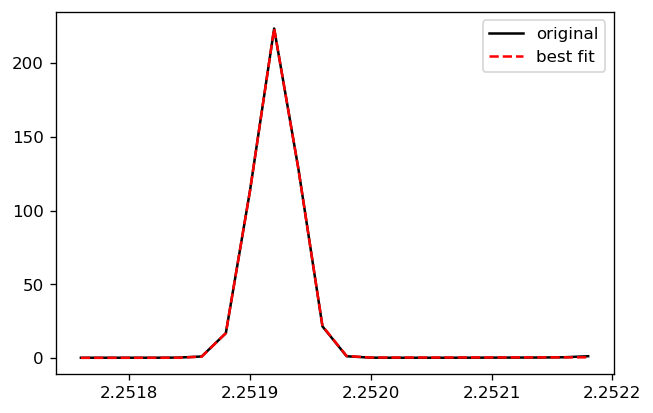

In [37]:
x2 = wavelength[688:710]
y2 = count[688:710]

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=220)
g2_params.add('a1', value=2.25192, min=2.2518)
g2_params.add('a2', value=0.004)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(y2, g2_params, x=x2)
except:
    pass

print(g2_result.fit_report())

plt.figure()
plt.plot(x2, y2, 'k', label='original')
plt.plot(x2, g2_result.best_fit, 'r--', label='best fit')
plt.legend()

print(g2_result.params['a1'].value)

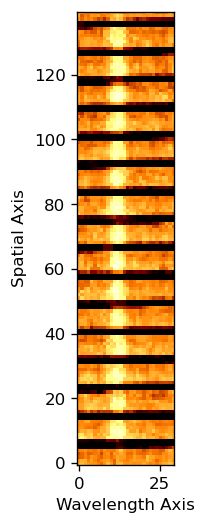

In [167]:
a = np.delete(skylines60m, np.s_[120:], 1)
b = np.delete(a, np.s_[:90], 1)

plt.figure(figsize=(2,5))
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

i = 25
i = 30
i = 35
i = 45
i = 55
i = 60
i = 65
i = 70
i = 80
i = 90
i = 95
i = 105
i = 115
i = 120
i = 125
i = 130


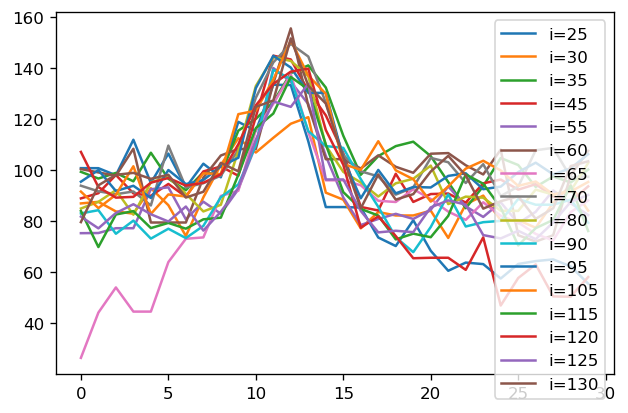

In [206]:
for i in range(len(b)):
    if i%5==0 and i not in (0,5,10,15,20,40,50,75,85,100,110,135):
        print ('i = ' +str(i))
#         plt.figure()
        plt.plot(b[i], label='i='+str(i))
#         plt.title('i='+str(i))
        plt.legend()

In [207]:
a = np.delete(skylines60m, np.s_[120:], 1)
b = np.delete(a, np.s_[:90], 1)
b = normalize(b)
waveaxis = np.linspace(0, np.size(b,1)-1, np.size(b,1))
# waveaxis = waverange[810:860]*100000

upper_skyline = 135
lower_skyline = 15

sky1_a1 = []
sky1_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5==0 and i not in (0,5,10,15,20,40,50,75,85,100,110,135):
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7, min=0)
        sky1_params.add('a1', value=12, min=10, max=15)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
# sky1_a1 = np.array(sky1_a1)/100000
sky1_a1 = np.array(sky1_a1)+90

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 16
    # variables        = 1
    chi-square         = 1.57932620
    reduced chi-square = 0.10528841
    Akaike info crit   = -35.0494468
    Bayesian info crit = -34.2768580
[[Variables]]
    c:  101.798873 +/- 0.08112044 (0.08%) (init = 101.7989)


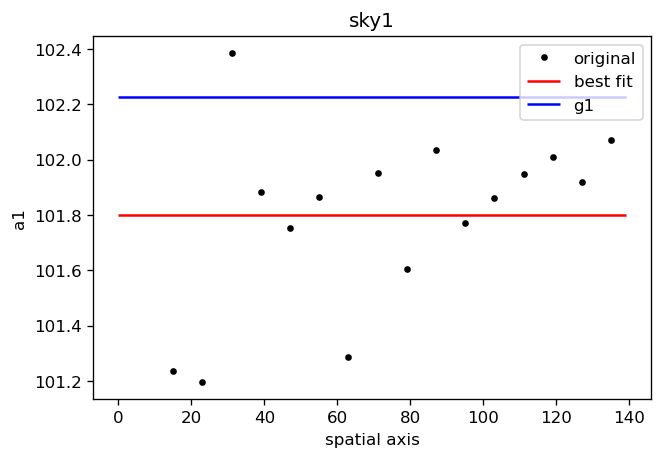

In [208]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

# sky1_a = out.params['a'].value
# sky1_b = out.params['b'].value
sky1_c = out.params['c'].value

sky1_spat_all = np.linspace(0, np.size(skylines60m,0)-1, np.size(skylines60m,0))
# sky1_a1_best_fit = sky1_a*sky1_spat_all**2+sky1_b*sky1_spat_all+sky1_c
sky1_a1_best_fit = sky1_c

plt.figure()
plt.plot(sky1_spat, sky1_a1,'k.', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.hlines((2.24602-y0)/m, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.title('sky1')
plt.ticklabel_format(useOffset=False)
plt.legend()

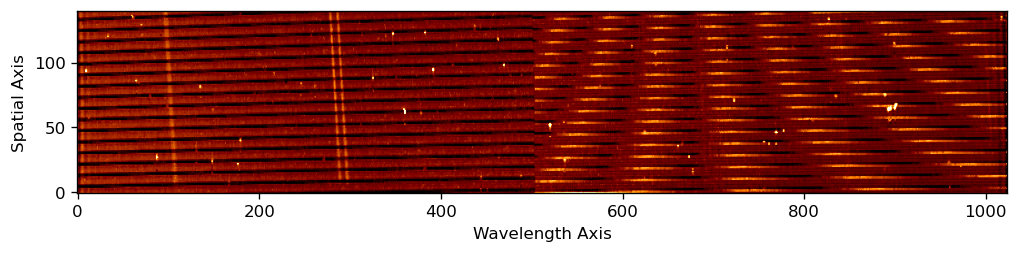

In [209]:
plt.figure(figsize=(10,2))
plt.imshow(skylines60p, aspect='auto', cmap='afmhot')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0],waverange[-1],0,138], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

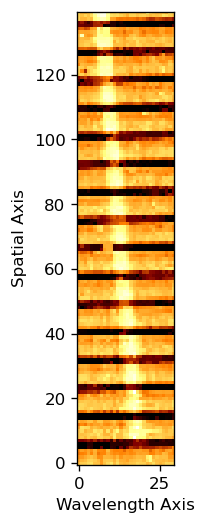

In [210]:
c = np.delete(skylines60p, np.s_[120:], 1)
d = np.delete(c, np.s_[:90], 1)

plt.figure(figsize=(2,5))
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

i = 25
i = 30
i = 35
i = 45
i = 55
i = 60
i = 65
i = 70
i = 80
i = 90
i = 95
i = 105
i = 115
i = 120
i = 125
i = 130


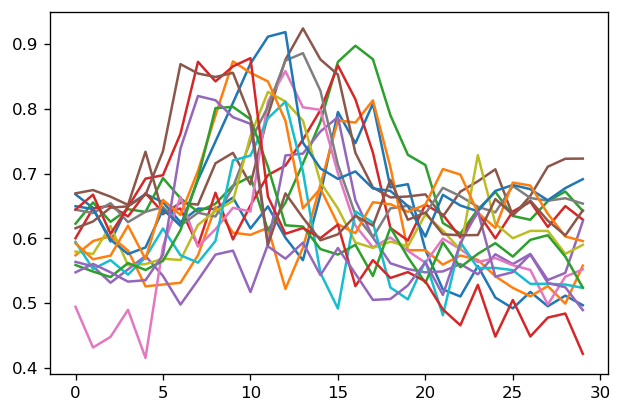

In [226]:
for i in range(len(d)):
    if i%5==0 and i not in (0,5,10,15,20,40,50,75,85,100,110,135):
        print ('i = ' +str(i))
#         plt.figure()
        plt.plot(d[i], label='i='+str(i))
#         plt.title('i='+str(i))
#         plt.legend()

In [227]:
c = np.delete(skylines60p, np.s_[120:], 1)
d = np.delete(c, np.s_[:90], 1)
d = normalize(d)
waveaxis = np.linspace(0, np.size(d,1)-1, np.size(d,1))
# waveaxis = waverange[810:860]*100000

upper_skyline = 135
lower_skyline = 15

sky1_a1 = []
sky1_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5==0 and i not in (0,5,10,15,20,40,50,75,85,100,110,135) and i<=75:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.8, min=0.2)
        sky1_params.add('a1', value=15, min=0, max=20)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(d[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
    
    if i%5==0 and i not in (0,5,10,15,20,40,50,75,85,100,110,135) and i>75:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.8, min=0.2, max=0.9)
        sky1_params.add('a1', value=10, min=4, max=14)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.55)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(d[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
    
# sky1_a1 = np.array(sky1_a1)/100000
sky1_a1 = np.array(sky1_a1)+90

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 16
    # variables        = 2
    chi-square         = 1.39571240
    reduced chi-square = 0.09969374
    Akaike info crit   = -35.0269401
    Bayesian info crit = -33.4817626
[[Variables]]
    slope:     -0.07811265 +/- 0.00214045 (2.74%) (init = -0.07811265)
    intercept:  107.825024 +/- 0.17889068 (0.17%) (init = 107.825)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.897


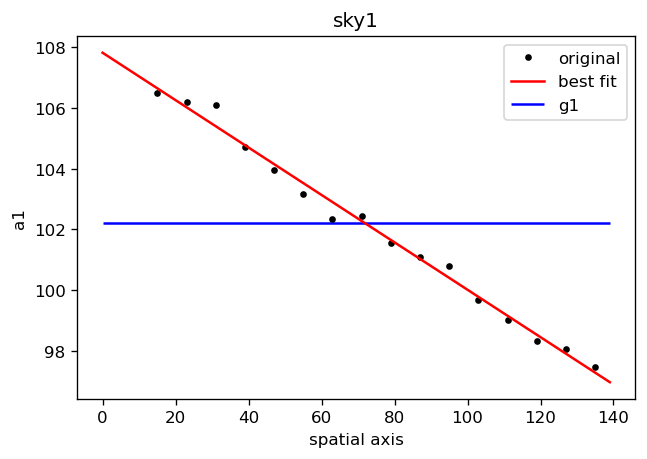

In [228]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky1_spat
y = sky1_a1

mod = LinearModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_k = out.params['slope'].value
sky1_b = out.params['intercept'].value

sky1_spat_all = np.linspace(0, np.size(skylines60m,0)-1, np.size(skylines60m,0))
sky1_a1_best_fit = sky1_k*sky1_spat_all + sky1_b

plt.figure()
plt.plot(sky1_spat, sky1_a1,'k.', label = 'original')
plt.plot(sky1_spat_all, sky1_a1_best_fit, 'r', label = 'best fit')
# plt.hlines(99.05681990966845, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label = 'best fit')
plt.hlines((2.24602-y0)/m, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('sky1')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [230]:
sky1_pixel_offset_order34 = (2.24602-y0)/m - sky1_a1_best_fit
# np.savetxt('skylines60p_offset_order34.txt', sky1_pixel_offset_order34)
sky1_pixel_offset_order34

array([-5.59985964, -5.52174699, -5.44363434, -5.36552169, -5.28740904,
       -5.20929639, -5.13118374, -5.05307109, -4.97495844, -4.89684579,
       -4.81873314, -4.74062049, -4.66250784, -4.58439519, -4.50628254,
       -4.42816989, -4.35005724, -4.27194459, -4.19383194, -4.11571929,
       -4.03760664, -3.95949399, -3.88138134, -3.80326869, -3.72515604,
       -3.64704339, -3.56893074, -3.49081809, -3.41270544, -3.33459279,
       -3.25648014, -3.17836749, -3.10025484, -3.02214219, -2.94402954,
       -2.86591689, -2.78780424, -2.70969159, -2.63157894, -2.55346629,
       -2.47535364, -2.39724099, -2.31912834, -2.24101569, -2.16290304,
       -2.08479039, -2.00667774, -1.92856509, -1.85045244, -1.77233979,
       -1.69422714, -1.61611449, -1.53800184, -1.45988919, -1.38177654,
       -1.30366389, -1.22555124, -1.14743859, -1.06932594, -0.99121329,
       -0.91310064, -0.83498799, -0.75687534, -0.67876269, -0.60065004,
       -0.52253739, -0.44442474, -0.36631209, -0.28819944, -0.21

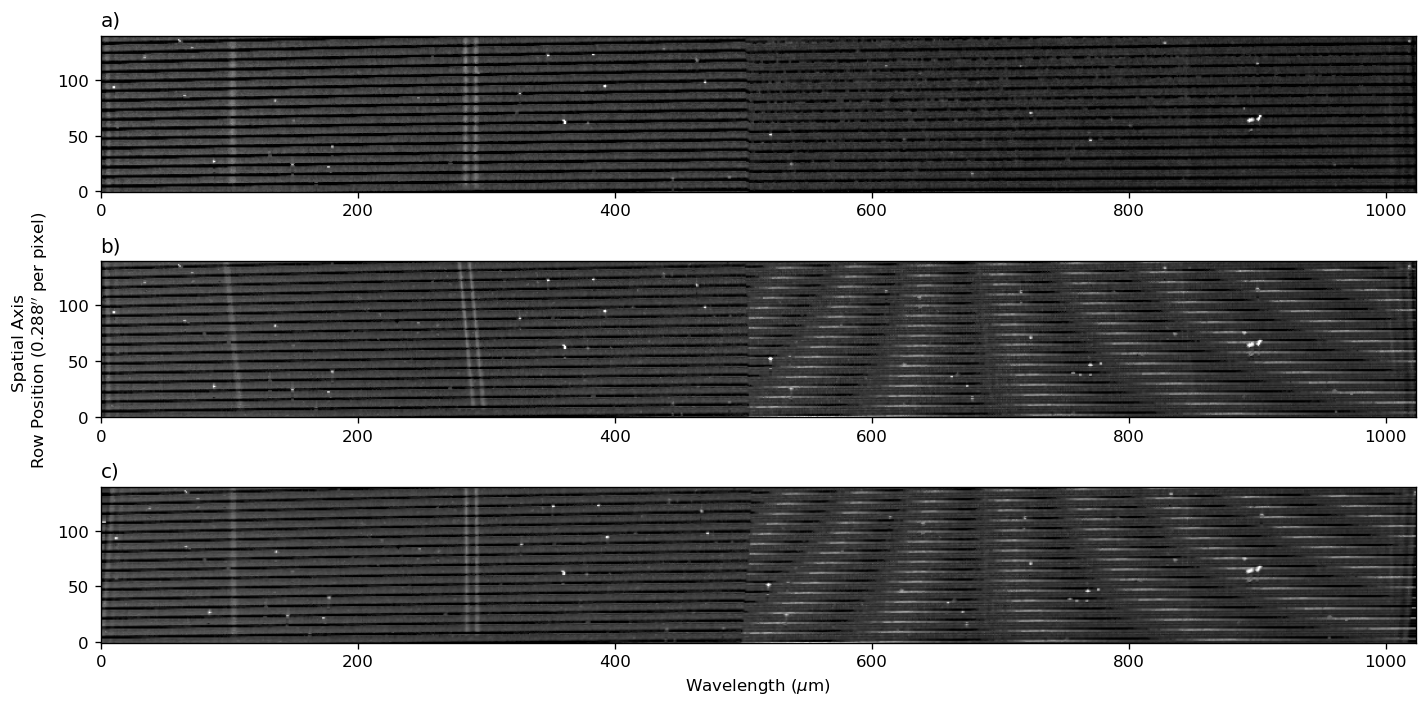

In [234]:
fig = plt.figure(figsize=(12,6), tight_layout=True)

fig.add_subplot(311)
plt.imshow(skylines60m, aspect='auto', cmap='gist_gray')
# plt.imshow(skylines60m, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
plt.title('a)', loc='left')
# plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(312)
plt.imshow(skylines60p, aspect='auto', cmap='gist_gray')
# plt.imshow(skylines60p, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
# plt.xlabel('Wavelength ($\mu$m)')
plt.title('b)', loc='left')
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(313)
plt.imshow(skylines60p_shifted, aspect='auto', cmap='gist_gray')
# plt.imshow(skylines60p_shifted, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
plt.title('c)', loc='left')
plt.xlabel('Wavelength ($\mu$m)')
plt.gca().invert_yaxis()

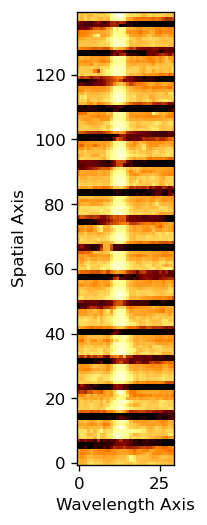

In [4]:
e = np.delete(skylines60p_shifted, np.s_[120:], 1)
f = np.delete(e, np.s_[:90], 1)

plt.figure(figsize=(2,5))
plt.imshow(f, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

i = 25
i = 30
i = 35
i = 45
i = 55
i = 60
i = 65
i = 70
i = 80
i = 90
i = 95
i = 105
i = 115
i = 120
i = 125
i = 130


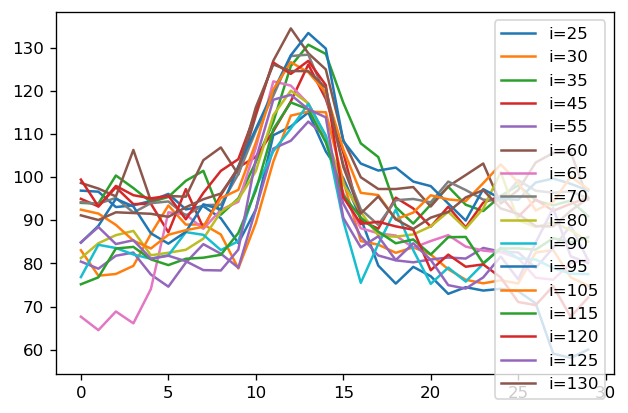

In [5]:
for i in range(len(f)):
    if i%5==0 and i not in (0,5,10,15,20,40,50,75,85,100,110,135):
        print ('i = ' +str(i))
#         plt.figure()
        plt.plot(f[i], label='i='+str(i))
#         plt.title('i='+str(i))
        plt.legend()

In [6]:
e = np.delete(skylines60p_shifted, np.s_[120:], 1)
f = np.delete(e, np.s_[:90], 1)
f = normalize(f)
waveaxis = np.linspace(0, np.size(f,1)-1, np.size(f,1))
# waveaxis = waverange[810:860]*100000

upper_skyline = 135
lower_skyline = 15

sky1_a1 = []
sky1_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5==0 and i not in (0,5,10,15,20,40,50,75,85,100,110,135):
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7, min=0)
        sky1_params.add('a1', value=12.5, min=11, max=14)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(f[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
sky1_a1 = np.array(sky1_a1)+90

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 16
    # variables        = 1
    chi-square         = 2.15611983
    reduced chi-square = 0.14374132
    Akaike info crit   = -30.0684558
    Bayesian info crit = -29.2958671
[[Variables]]
    c:  102.449345 +/- 0.09478308 (0.09%) (init = 102.4493)


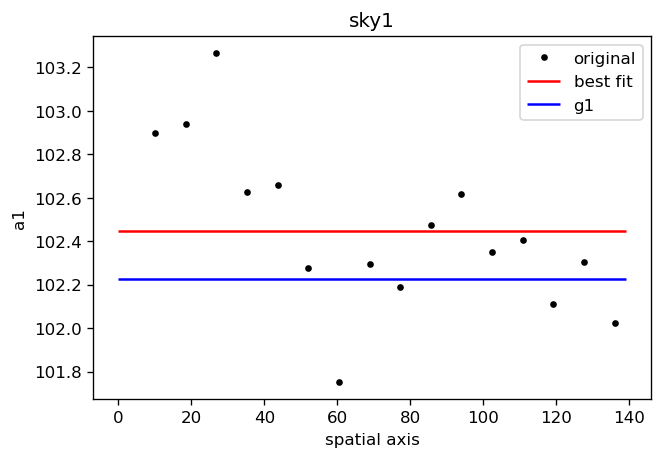

In [16]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

# sky1_a = out.params['a'].value
# sky1_b = out.params['b'].value
sky1_c = out.params['c'].value

sky1_spat_all = np.linspace(0, np.size(skylines60p_shifted,0)-1, np.size(skylines60p_shifted,0))
# sky1_a1_best_fit = sky1_a*sky1_spat_all**2+sky1_b*sky1_spat_all+sky1_c
sky1_a1_best_fit = sky1_c

plt.figure()
plt.plot(sky1_spat, sky1_a1,'k.', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.hlines((2.24602-y0)/m, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.title('sky1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [8]:
sky1_a1_best_fit

102.4493450335806

In [27]:
sky1_wave_best_fit = sky1_a1_best_fit*m + y0
sky1_wave_best_fit

2.2460269495925784

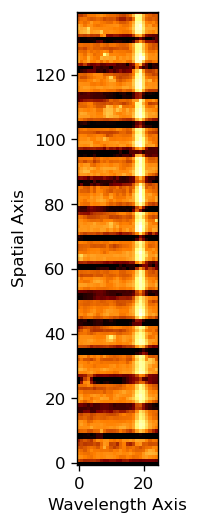

In [9]:
g = np.delete(skylines60p_shifted, np.s_[290:], 1)
h = np.delete(g, np.s_[:265], 1)

plt.figure(figsize=(2,5))
plt.imshow(h, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

i = 10
i = 15
i = 20
i = 45
i = 50
i = 55
i = 65
i = 75
i = 80
i = 85
i = 90
i = 100
i = 110
i = 115
i = 120
i = 125
i = 135


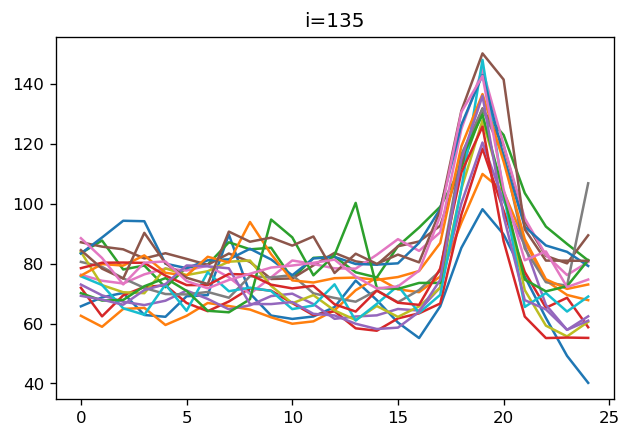

In [10]:
for i in range(len(h)):
    if i%5==0 and i not in (0,5,25,30,35,40,60,70,95,105,130):
        print ('i = ' +str(i))
#         plt.figure()
        plt.plot(h[i], label='i='+str(i))
        plt.title('i='+str(i))
#         plt.legend()

In [23]:
g = np.delete(skylines60p_shifted, np.s_[290:], 1)
h = np.delete(g, np.s_[:265], 1)
h = normalize(h)
waveaxis = np.linspace(0, np.size(h,1)-1, np.size(h,1))

upper_skyline = 136
lower_skyline = 10

sky2_a1 = []
sky2_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5==0 and i not in (0,5,25,30,35,40,60,70,95,105,130):
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.8, min=0)
        sky2_params.add('a1', value=19, min=16, max=22)
        sky2_params.add('a2', value=2)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(h[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, h[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1.append(sky2_fit_result.params['a1'].value)
sky2_a1 = np.array(sky2_a1)+265

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 17
    # variables        = 1
    chi-square         = 0.69956527
    reduced chi-square = 0.04372283
    Akaike info crit   = -52.2386619
    Bayesian info crit = -51.4054486
[[Variables]]
    c:  284.012606 +/- 0.05071421 (0.02%) (init = 284.0126)


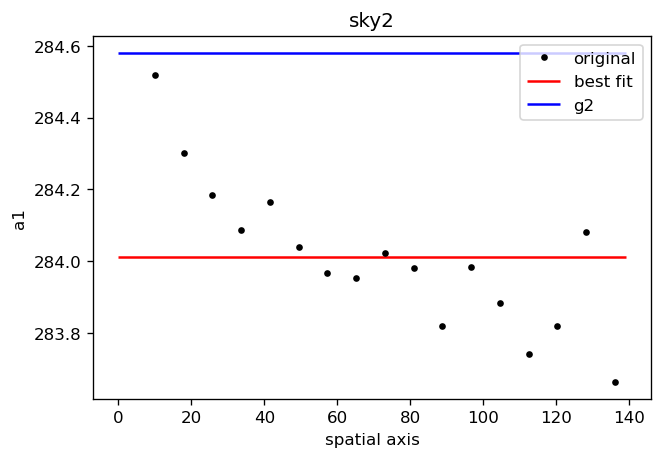

In [24]:
sky2_spat = np.linspace(lower_skyline, upper_skyline, len(sky2_a1))

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

# sky2_a = out.params['a'].value
# sky2_b = out.params['b'].value
sky2_c = out.params['c'].value

sky2_spat_all = np.linspace(0, np.size(skylines60p_shifted,0)-1, np.size(skylines60p_shifted,0))
# sky2_a1_best_fit = sky2_a*sky2_spat_all**2+sky2_b*sky2_spat_all+sky2_c
sky2_a1_best_fit = sky2_c

plt.figure()
plt.plot(sky2_spat, sky2_a1,'k.', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines((2.2516730208690925-y0)/m, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.title('sky2')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [25]:
sky2_a1_best_fit

284.0126056227294

In [28]:
sky2_wave_best_fit = sky2_a1_best_fit*m + y0
sky2_wave_best_fit

2.2516554114784966

In [29]:
print(sky1_wave_best_fit)
print(sky2_wave_best_fit)
print(sky1_a1_best_fit)
print(sky2_a1_best_fit)

R = (sky1_wave_best_fit + sky2_wave_best_fit)*0.5/((sky2_wave_best_fit - sky1_wave_best_fit)/(sky2_a1_best_fit - sky1_a1_best_fit))
R

2.2460269495925784
2.2516554114784966
102.4493450335806
284.0126056227294


72543.25347866818